# Classification with decision trees

In this notebook, we will use decision trees to classify the data. We will use the `DecisionTreeClassifier` class from the `sklearn.tree` module. Decision trees are a popular method for various machine learning tasks. They are easy to understand and interpret, and they are often used as a baseline for more complex models.

We start by loading the data and preparing the train set and the test set.

In [13]:
import pandas as pd
from os import path
import numpy as np

races_final_path = path.join('..','dataset', 'engineered_races.csv')
cyclists_final_path = path.join('..','dataset', 'cyclists_final_enhanced.csv')


cyclists_data = pd.read_csv(cyclists_final_path)
races_data = pd.read_csv(races_final_path)

In [14]:

cyclists_data.rename(columns={'name': 'cyclist'}, inplace=True)


merged_data = races_data.merge(cyclists_data, left_on='cyclist', right_on='_url', how='inner')

merged_data['top_20'] = merged_data['position'].apply(lambda x: 1 if x <= 20 else 0)


merged_data['date'] = pd.to_datetime(merged_data['date'])

columns_to_keep = [
    'bmi', 'career_points','career_duration(days)','debut_year', 'difficulty_score', 'competitive_age', 'is_tarmac', 'points',
    'climbing_efficiency', 'startlist_quality', 'top_20'
]


train_set = merged_data[merged_data['date'] < '2022-01-01']
test_set = merged_data[merged_data['date'] >= '2022-01-01']

train_set = train_set[columns_to_keep]
test_set = test_set[columns_to_keep]

X_train = train_set.drop(columns=['top_20'])
y_train = train_set['top_20']


X_test = test_set.drop(columns=['top_20'])
y_test = test_set['top_20']

In [16]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy=0.90)
X_train, y_train = oversample.fit_resample(X_train, y_train)


So the data is set up however we need to evaluate training data to see which approach works best.

In [ ]:
X_train.shape

(875223, 10)

In [ ]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definition of the hyperparameters grid
param_grid = {
    'criterion': ['gini', 'entropy'],   # Try different impurity criteria
    'splitter': ['best', 'random'],     # Try different splitting strategies
    'max_depth': [5, 10, 15],           # Max depth of the tree
    'min_samples_split': [2, 10, 20],   # Min samples required to split a node
    'min_samples_leaf': [1, 5, 10],     # Min samples required at each leaf node
}

# Decision tree model
dt = DecisionTreeClassifier()

# Grid search
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1',  # Use the F1 score
    cv=4,       # 5-fold cross-validation
    verbose=1,  # Print info
    n_jobs=-1   # Use all available cores
)

# Execute the grid search
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Print the best f1 score
print("Best f1 score:", grid_search.best_score_)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best f1 score: 0.7307935197406766


In [ ]:
dt = best_model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0230136 to fit



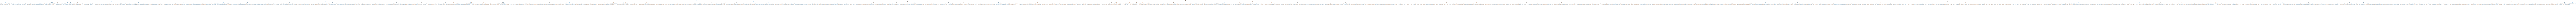

In [ ]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
from sklearn import tree
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(X_train.columns),  
                         class_names=['0', '1'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Now we will predict on the train and test data and evaluate the performance of the model using the accuracy score.

In [ ]:
train_pred_dt = dt.predict(X_train)
test_pred_dt = dt.predict(X_test)


In [ ]:
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(y_train, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(y_test, test_pred_dt))
print('Precision train set ', metrics.precision_score(y_train, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(y_train, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(y_train, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(y_train, train_pred_dt))


Accuracy train set  0.7792299791024687
Accuracy test set  0.786081455120601
Precision train set  0.7792237030142896
Recall train set  0.7792299791024687
F1 score train set  0.7788964818720343
Support train set  (array([0.77936847, 0.77906285]), array([0.80977718, 0.74528859]), array([0.79428189, 0.76180156]), array([460644, 414579]))


In [ ]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [ ]:
report_scores(y_test, test_pred_dt)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     30219
           1       0.30      0.34      0.32      5187

    accuracy                           0.79     35406
   macro avg       0.59      0.60      0.60     35406
weighted avg       0.80      0.79      0.79     35406



As you can see the model performs weel to predict the cyclists that do not enter in the top 20. However, the model does not perform well to predict the cyclists that enter in the top 20. The model has a high recall on the positive class, but at the cost of a low precision.

We will try other models like Random Forest and Boosting to see if we can improve the performances.